In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
df = pd.read_csv('./bean_3mers.csv')
df.head(2)

,chromosome,window_start,window_end,rec,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,chr1,1.0,100000.0,0.00,721.0,274.0,290.0,459.0,266.0,132.0,...,53.0,234.0,249.0,147.0,156.0,192.0,274.0,296.0,268.0,489.0
1,chr1,100001.0,200000.0,1.32,3689.0,1397.0,1589.0,2923.0,1544.0,819.0,...,402.0,1738.0,1676.0,864.0,1186.0,1685.0,2387.0,1931.0,1941.0,4311.0


# Recombination smoothing

In [3]:
df = df
df['srec'] = 0

for i in  range(1, len(df)):
    if df.loc[i-1,'chromosome'] == df.loc[i,'chromosome']:
        df.loc[i, 'srec'] = df.loc[i-1, 'rec']*0.1 + df.loc[i-1, 'srec']*0.9

In [4]:
df = df.dropna()

# Chromosome Split

Testing data with chromosome info

In [5]:
# Dataframes with chrs info
chr1 = df[df["chromosome"] == "chr1"]
chr2 = df[df["chromosome"] == "chr2"]
chr3 = df[df["chromosome"] == "chr3"]
chr4 = df[df["chromosome"] == "chr4"]
chr5 = df[df["chromosome"] == "chr5"]
chr6 = df[df["chromosome"] == "chr6"]
chr7 = df[df["chromosome"] == "chr7"]
chr8 = df[df["chromosome"] == "chr8"]
chr9 = df[df["chromosome"] == "chr9"]
chr10 = df[df["chromosome"] == "chr10"]
chr11 = df[df["chromosome"] == "chr11"]

Training data without the chromosome to be predicted

In [6]:
# Dataframes with the remaining chrs info
achr1 = df[df["chromosome"] != "chr1"]
achr2 = df[df["chromosome"] != "chr2"]
achr3 = df[df["chromosome"] != "chr3"]
achr4 = df[df["chromosome"] != "chr4"]
achr5 = df[df["chromosome"] != "chr5"]
achr6 = df[df["chromosome"] != "chr6"]
achr7 = df[df["chromosome"] != "chr7"]
achr8 = df[df["chromosome"] != "chr8"]
achr9 = df[df["chromosome"] != "chr9"]
achr10 = df[df["chromosome"] != "chr10"]
achr11 = df[df["chromosome"] != "chr11"]

# Model Predictions

Predictions on each chromosome, using the information from the remaining chromosomes as a training set. For example, if chromosome 1 is to be predicted, the training set will be composed of chromosomes 2, 3, 4.... etc. 

Correlation: 0.7383911709232456
Coefficient of Determination: 0.47665965225489937
Mean Squared Error: 0.01771158767239739


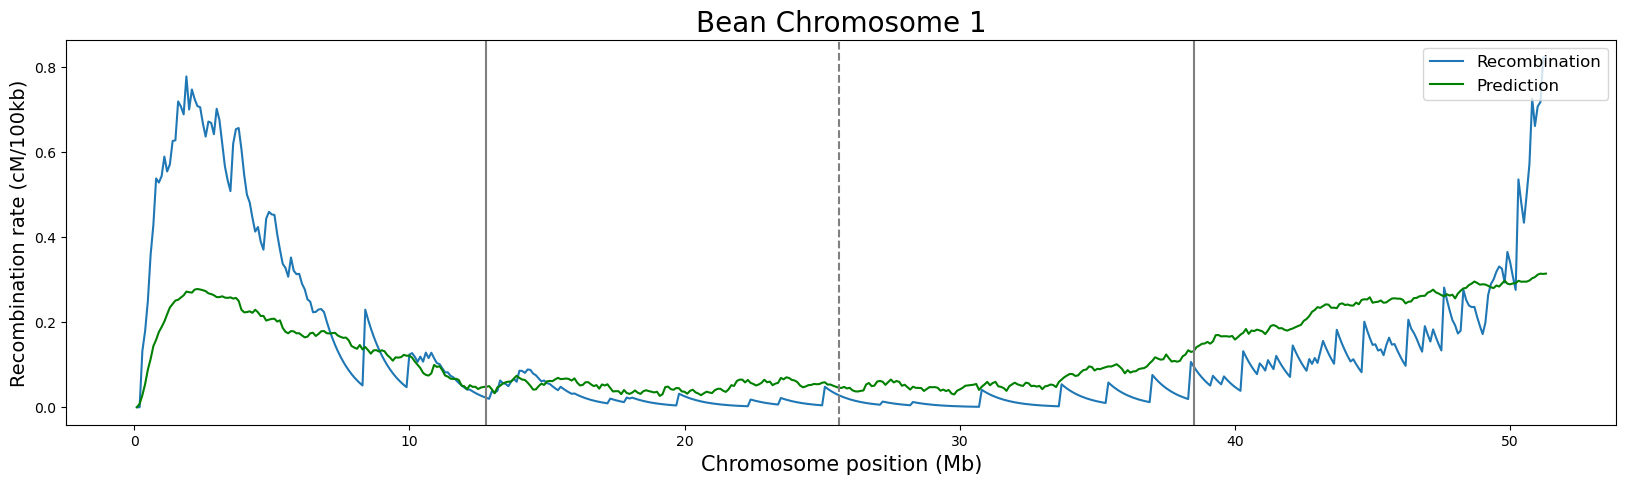

In [7]:
# TRAINING MODEL
X = achr1.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr1.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr1.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr1 = model_spreds      
    
#PARAMETERS
corr_chr1 = pearsonr(chr1.srec, pchr1)
r2_chr1 = r2_score(chr1.srec, pchr1)
mse_chr1 = mean_squared_error(chr1.srec, pchr1)
print('Correlation:', corr_chr1[0])
print('Coefficient of Determination:', r2_chr1)
print('Mean Squared Error:', mse_chr1)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr1)*0.25)
c_q2 = int(len(chr1)*0.50)
c_q3 = int(len(chr1)*0.75)

rq1 = chr1['srec'].iloc[0:c_q1]
rq2 = chr1['srec'].iloc[c_q1:c_q2]
rq3 = chr1['srec'].iloc[c_q2:c_q3]
rq4 = chr1['srec'].iloc[c_q3:int(len(chr1))]

pq1 = pchr1[0:c_q1]
pq2 = pchr1[c_q1:c_q2]
pq3 = pchr1[c_q2:c_q3]
pq4 = pchr1[c_q3:int(len(chr1))]

corr_chr1_q1 = pearsonr(rq1, pq1)
corr_chr1_q2 = pearsonr(rq2, pq2)
corr_chr1_q3 = pearsonr(rq3, pq3)
corr_chr1_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr1. window_end,chr1.srec, label='Recombination')
ax.plot(chr1. window_end,pchr1, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 1',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr1["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7988334055336377
Coefficient of Determination: 0.548439315288072
Mean Squared Error: 0.007689006937196233


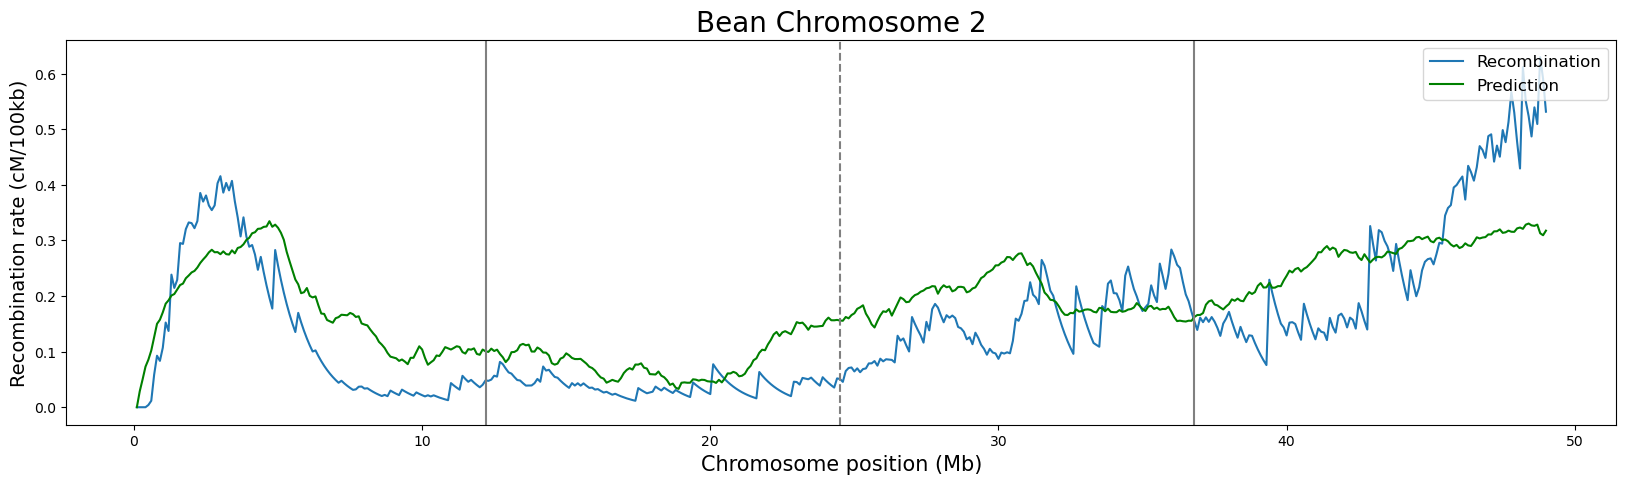

In [8]:
# TRAINING MODEL
X = achr2.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr2.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr2.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr2 = model_spreds      
    
#PARAMETERS
corr_chr2 = pearsonr(chr2.srec, pchr2)
r2_chr2 = r2_score(chr2.srec, pchr2)
mse_chr2 = mean_squared_error(chr2.srec, pchr2)
print('Correlation:', corr_chr2[0])
print('Coefficient of Determination:', r2_chr2)
print('Mean Squared Error:', mse_chr2)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr2)*0.25)
c_q2 = int(len(chr2)*0.50)
c_q3 = int(len(chr2)*0.75)

rq1 = chr2['srec'].iloc[0:c_q1]
rq2 = chr2['srec'].iloc[c_q1:c_q2]
rq3 = chr2['srec'].iloc[c_q2:c_q3]
rq4 = chr2['srec'].iloc[c_q3:int(len(chr2))]

pq1 = pchr2[0:c_q1]
pq2 = pchr2[c_q1:c_q2]
pq3 = pchr2[c_q2:c_q3]
pq4 = pchr2[c_q3:int(len(chr2))]

corr_chr2_q1 = pearsonr(rq1, pq1)
corr_chr2_q2 = pearsonr(rq2, pq2)
corr_chr2_q3 = pearsonr(rq3, pq3)
corr_chr2_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr2. window_end,chr2.srec, label='Recombination')
ax.plot(chr2. window_end,pchr2, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 2',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr2["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7085239518098605
Coefficient of Determination: 0.4622572473117065
Mean Squared Error: 0.012431254056272425


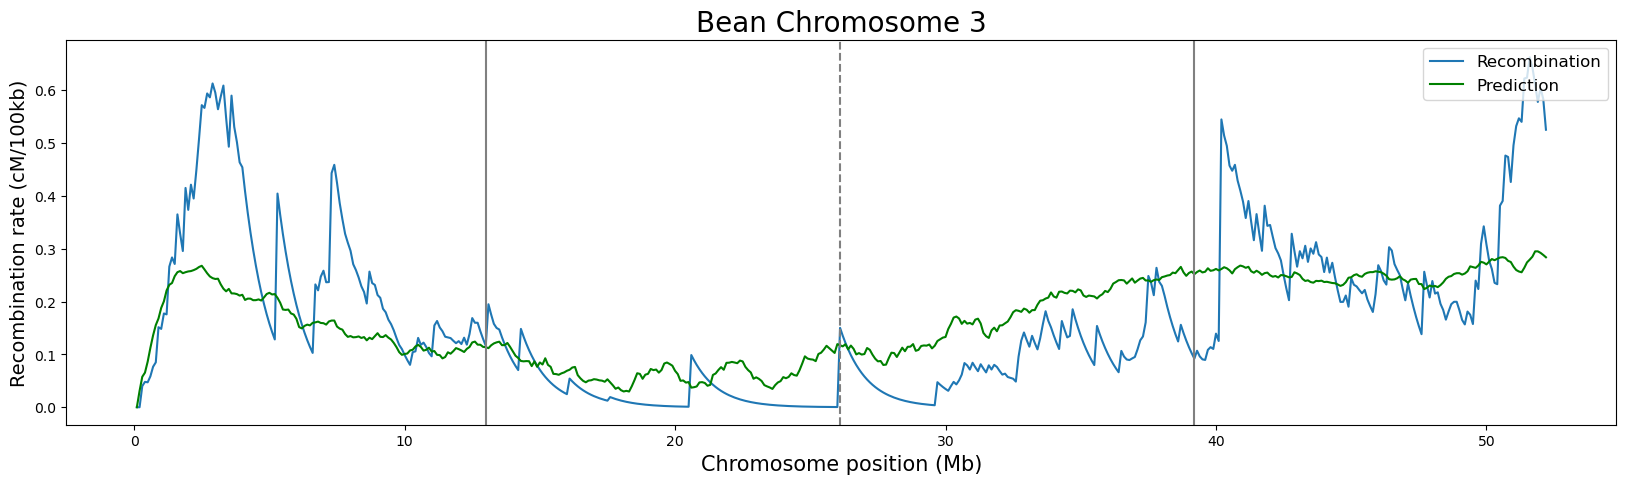

In [9]:
# TRAINING MODEL
X = achr3.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr3.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr3.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr3 = model_spreds      
    
#PARAMETERS
corr_chr3 = pearsonr(chr3.srec, pchr3)
r2_chr3 = r2_score(chr3.srec, pchr3)
mse_chr3 = mean_squared_error(chr3.srec, pchr3)
print('Correlation:', corr_chr3[0])
print('Coefficient of Determination:', r2_chr3)
print('Mean Squared Error:', mse_chr3)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr3)*0.25)
c_q2 = int(len(chr3)*0.50)
c_q3 = int(len(chr3)*0.75)

rq1 = chr3['srec'].iloc[0:c_q1]
rq2 = chr3['srec'].iloc[c_q1:c_q2]
rq3 = chr3['srec'].iloc[c_q2:c_q3]
rq4 = chr3['srec'].iloc[c_q3:int(len(chr3))]

pq1 = pchr3[0:c_q1]
pq2 = pchr3[c_q1:c_q2]
pq3 = pchr3[c_q2:c_q3]
pq4 = pchr3[c_q3:int(len(chr3))]

corr_chr3_q1 = pearsonr(rq1, pq1)
corr_chr3_q2 = pearsonr(rq2, pq2)
corr_chr3_q3 = pearsonr(rq3, pq3)
corr_chr3_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr3. window_end,chr3.srec, label='Recombination')
ax.plot(chr3. window_end,pchr3, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 3',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr3["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7896375139054779
Coefficient of Determination: 0.5139443610386318
Mean Squared Error: 0.014944058488911043


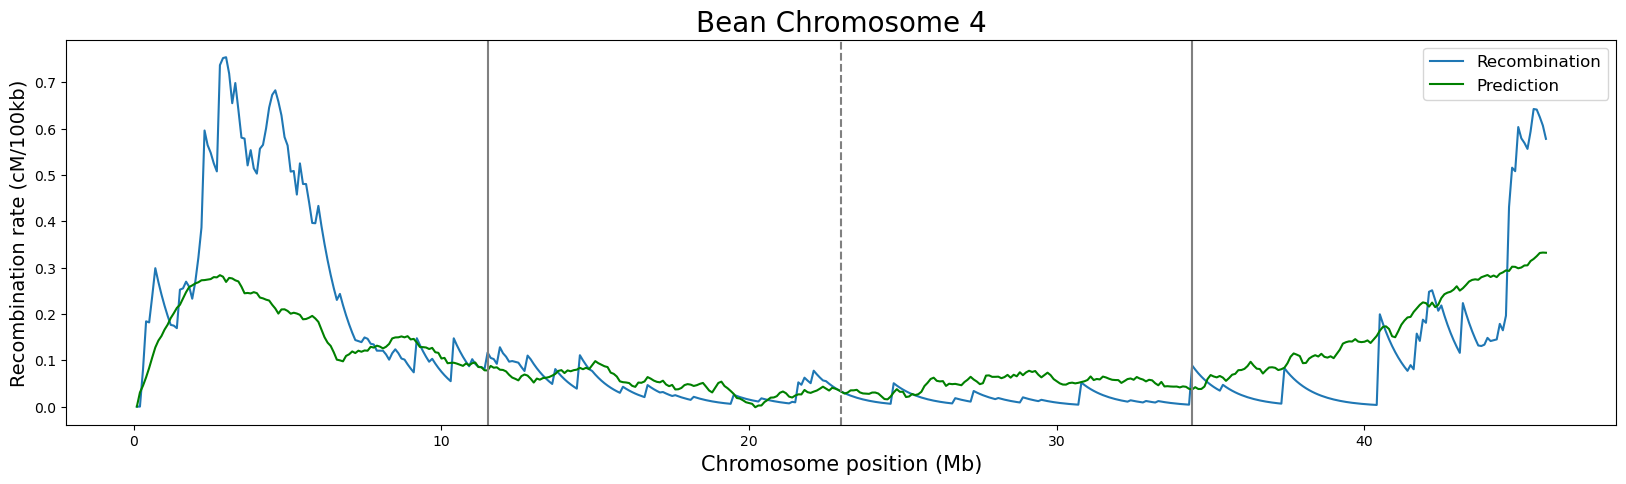

In [10]:
# TRAINING MODEL
X = achr4.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr4.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr4.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr4 = model_spreds      
    
#PARAMETERS
corr_chr4 = pearsonr(chr4.srec, pchr4)
r2_chr4 = r2_score(chr4.srec, pchr4)
mse_chr4 = mean_squared_error(chr4.srec, pchr4)
print('Correlation:', corr_chr4[0])
print('Coefficient of Determination:', r2_chr4)
print('Mean Squared Error:', mse_chr4)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr4)*0.25)
c_q2 = int(len(chr4)*0.50)
c_q3 = int(len(chr4)*0.75)

rq1 = chr4['srec'].iloc[0:c_q1]
rq2 = chr4['srec'].iloc[c_q1:c_q2]
rq3 = chr4['srec'].iloc[c_q2:c_q3]
rq4 = chr4['srec'].iloc[c_q3:int(len(chr4))]

pq1 = pchr4[0:c_q1]
pq2 = pchr4[c_q1:c_q2]
pq3 = pchr4[c_q2:c_q3]
pq4 = pchr4[c_q3:int(len(chr4))]

corr_chr4_q1 = pearsonr(rq1, pq1)
corr_chr4_q2 = pearsonr(rq2, pq2)
corr_chr4_q3 = pearsonr(rq3, pq3)
corr_chr4_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr4. window_end,chr4.srec, label='Recombination')
ax.plot(chr4. window_end,pchr4, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 4',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr4["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7909382488657857
Coefficient of Determination: 0.39114291976785387
Mean Squared Error: 0.033560799762255254


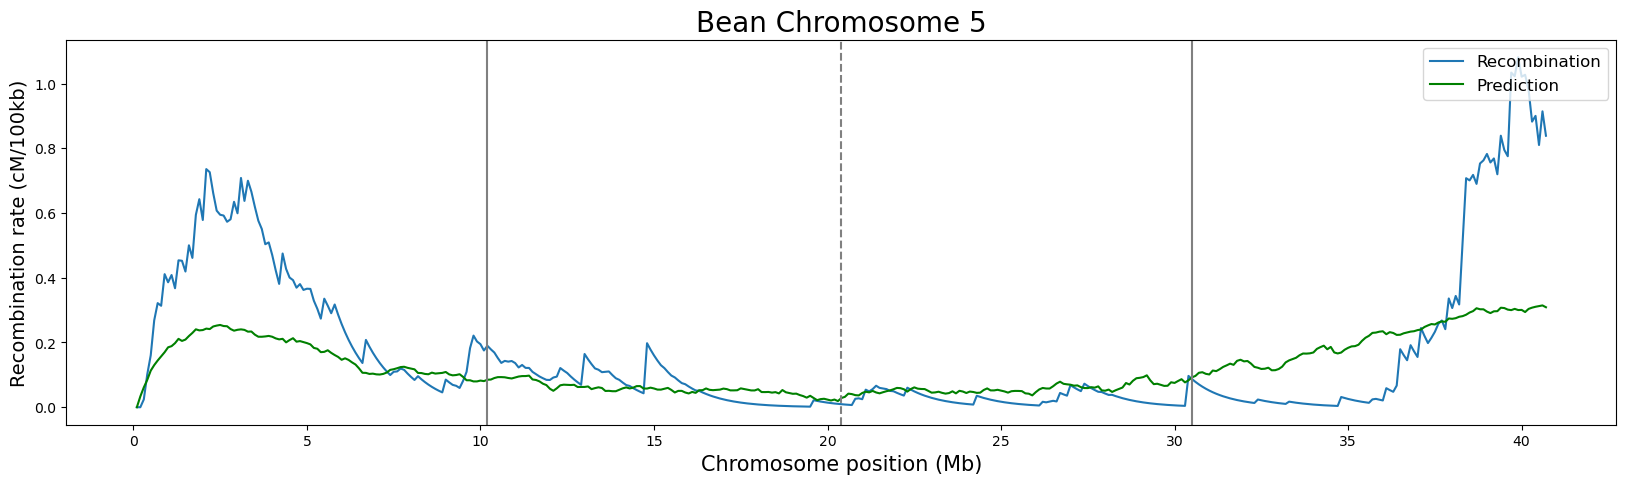

In [11]:
# TRAINING MODEL
X = achr5.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr5.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr5.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr5 = model_spreds      
    
#PARAMETERS
corr_chr5 = pearsonr(chr5.srec, pchr5)
r2_chr5 = r2_score(chr5.srec, pchr5)
mse_chr5 = mean_squared_error(chr5.srec, pchr5)
print('Correlation:', corr_chr5[0])
print('Coefficient of Determination:', r2_chr5)
print('Mean Squared Error:', mse_chr5)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr5)*0.25)
c_q2 = int(len(chr5)*0.50)
c_q3 = int(len(chr5)*0.75)

rq1 = chr5['srec'].iloc[0:c_q1]
rq2 = chr5['srec'].iloc[c_q1:c_q2]
rq3 = chr5['srec'].iloc[c_q2:c_q3]
rq4 = chr5['srec'].iloc[c_q3:int(len(chr5))]

pq1 = pchr5[0:c_q1]
pq2 = pchr5[c_q1:c_q2]
pq3 = pchr5[c_q2:c_q3]
pq4 = pchr5[c_q3:int(len(chr5))]

corr_chr5_q1 = pearsonr(rq1, pq1)
corr_chr5_q2 = pearsonr(rq2, pq2)
corr_chr5_q3 = pearsonr(rq3, pq3)
corr_chr5_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr5. window_end,chr5.srec, label='Recombination')
ax.plot(chr5. window_end,pchr5, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 5',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr5["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.9063897038414366
Coefficient of Determination: 0.7282654807721322
Mean Squared Error: 0.007064715872741153


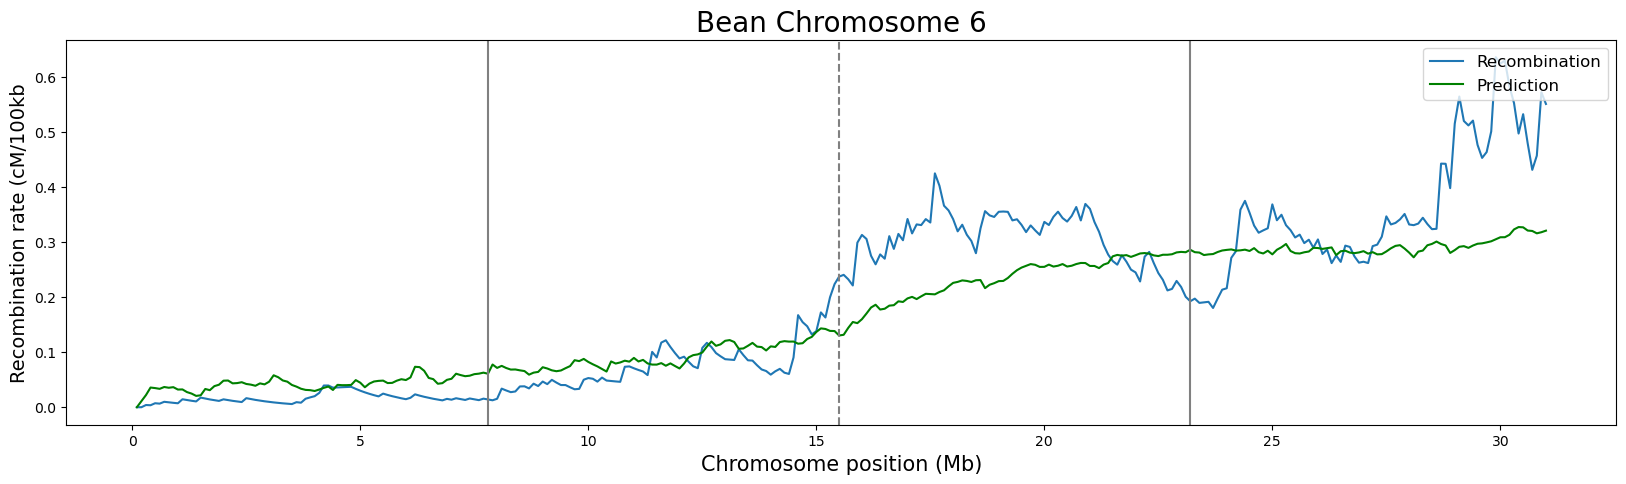

In [12]:
# TRAINING MODEL
X = achr6.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr6.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr6.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr6 = model_spreds      
    
#PARAMETERS
corr_chr6 = pearsonr(chr6.srec, pchr6)
r2_chr6 = r2_score(chr6.srec, pchr6)
mse_chr6 = mean_squared_error(chr6.srec, pchr6)
print('Correlation:', corr_chr6[0])
print('Coefficient of Determination:', r2_chr6)
print('Mean Squared Error:', mse_chr6)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr6)*0.25)
c_q2 = int(len(chr6)*0.50)
c_q3 = int(len(chr6)*0.75)

rq1 = chr6['srec'].iloc[0:c_q1]
rq2 = chr6['srec'].iloc[c_q1:c_q2]
rq3 = chr6['srec'].iloc[c_q2:c_q3]
rq4 = chr6['srec'].iloc[c_q3:int(len(chr6))]

pq1 = pchr6[0:c_q1]
pq2 = pchr6[c_q1:c_q2]
pq3 = pchr6[c_q2:c_q3]
pq4 = pchr6[c_q3:int(len(chr6))]

corr_chr6_q1 = pearsonr(rq1, pq1)
corr_chr6_q2 = pearsonr(rq2, pq2)
corr_chr6_q3 = pearsonr(rq3, pq3)
corr_chr6_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr6. window_end,chr6.srec, label='Recombination')
ax.plot(chr6. window_end,pchr6, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 6',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr6["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.6228965994399455
Coefficient of Determination: 0.0037825006433425123
Mean Squared Error: 0.03085848048842413


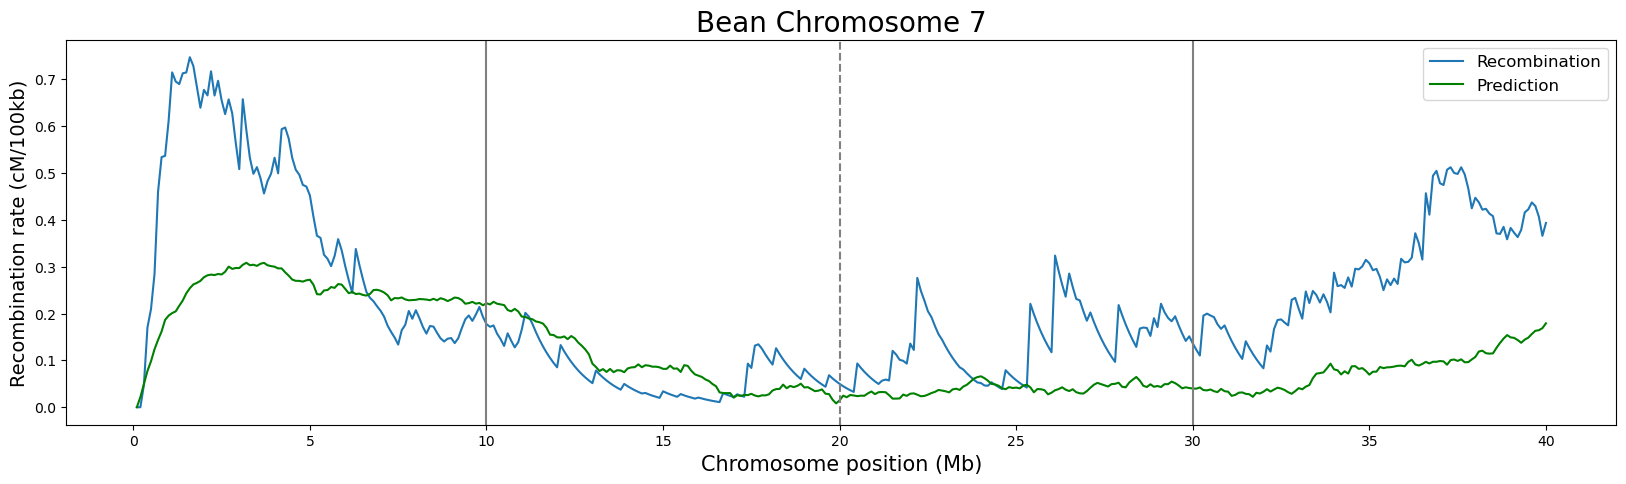

In [13]:
# TRAINING MODEL
X = achr7.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr7.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr7.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr7 = model_spreds      
    
#PARAMETERS
corr_chr7 = pearsonr(chr7.srec, pchr7)
r2_chr7 = r2_score(chr7.srec, pchr7)
mse_chr7 = mean_squared_error(chr7.srec, pchr7)
print('Correlation:', corr_chr7[0])
print('Coefficient of Determination:', r2_chr7)
print('Mean Squared Error:', mse_chr7)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr7)*0.25)
c_q2 = int(len(chr7)*0.50)
c_q3 = int(len(chr7)*0.75)

rq1 = chr7['srec'].iloc[0:c_q1]
rq2 = chr7['srec'].iloc[c_q1:c_q2]
rq3 = chr7['srec'].iloc[c_q2:c_q3]
rq4 = chr7['srec'].iloc[c_q3:int(len(chr7))]

pq1 = pchr7[0:c_q1]
pq2 = pchr7[c_q1:c_q2]
pq3 = pchr7[c_q2:c_q3]
pq4 = pchr7[c_q3:int(len(chr7))]

corr_chr7_q1 = pearsonr(rq1, pq1)
corr_chr7_q2 = pearsonr(rq2, pq2)
corr_chr7_q3 = pearsonr(rq3, pq3)
corr_chr7_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr7. window_end,chr7.srec, label='Recombination')
ax.plot(chr7. window_end,pchr7, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 7',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr7["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8709622254465794
Coefficient of Determination: 0.7283663441790624
Mean Squared Error: 0.004882492644176091


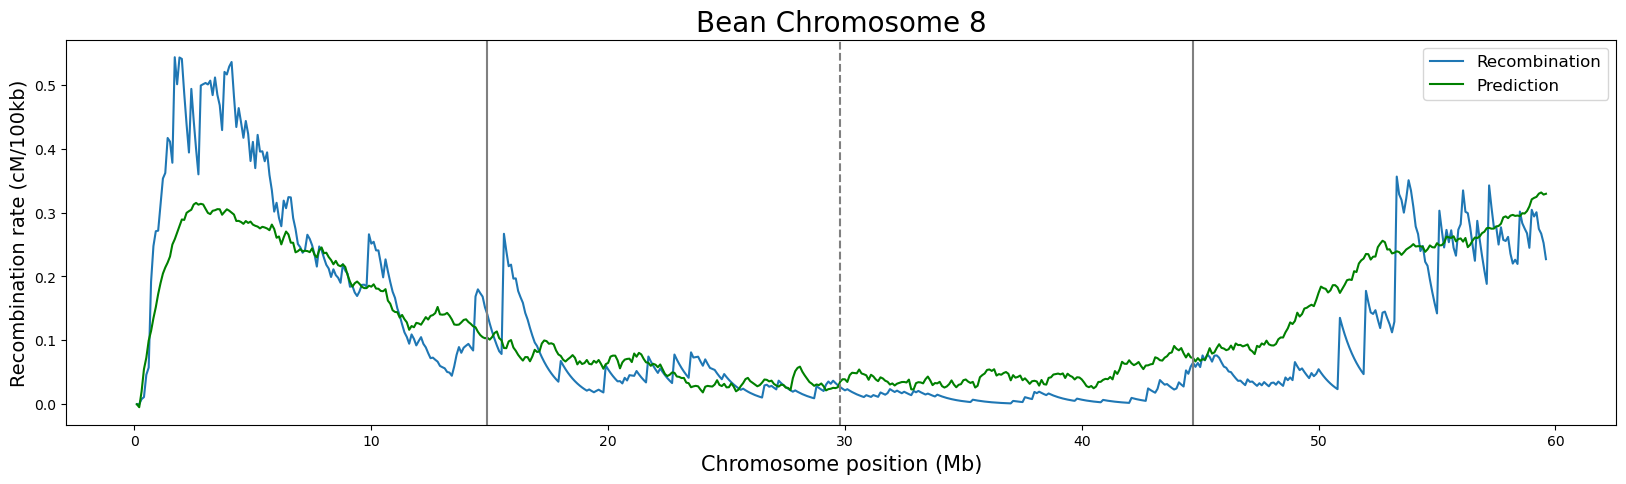

In [14]:
# TRAINING MODEL
X = achr8.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr8.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr8.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr8 = model_spreds      
    
#PARAMETERS
corr_chr8 = pearsonr(chr8.srec, pchr8)
r2_chr8 = r2_score(chr8.srec, pchr8)
mse_chr8 = mean_squared_error(chr8.srec, pchr8)
print('Correlation:', corr_chr8[0])
print('Coefficient of Determination:', r2_chr8)
print('Mean Squared Error:', mse_chr8)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr8)*0.25)
c_q2 = int(len(chr8)*0.50)
c_q3 = int(len(chr8)*0.75)

rq1 = chr8['srec'].iloc[0:c_q1]
rq2 = chr8['srec'].iloc[c_q1:c_q2]
rq3 = chr8['srec'].iloc[c_q2:c_q3]
rq4 = chr8['srec'].iloc[c_q3:int(len(chr8))]

pq1 = pchr8[0:c_q1]
pq2 = pchr8[c_q1:c_q2]
pq3 = pchr8[c_q2:c_q3]
pq4 = pchr8[c_q3:int(len(chr8))]

corr_chr8_q1 = pearsonr(rq1, pq1)
corr_chr8_q2 = pearsonr(rq2, pq2)
corr_chr8_q3 = pearsonr(rq3, pq3)
corr_chr8_q4 = pearsonr(rq4, pq4)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr8)*0.25)
c_q2 = int(len(chr8)*0.50)
c_q3 = int(len(chr8)*0.75)

rq1 = chr8['srec'].iloc[0:c_q1]
rq2 = chr8['srec'].iloc[c_q1:c_q2]
rq3 = chr8['srec'].iloc[c_q2:c_q3]
rq4 = chr8['srec'].iloc[c_q3:int(len(chr8))]

pq1 = pchr8[0:c_q1]
pq2 = pchr8[c_q1:c_q2]
pq3 = pchr8[c_q2:c_q3]
pq4 = pchr8[c_q3:int(len(chr8))]

corr_chr8_q1 = pearsonr(rq1, pq1)
corr_chr8_q2 = pearsonr(rq2, pq2)
corr_chr8_q3 = pearsonr(rq3, pq3)
corr_chr8_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr8. window_end,chr8.srec, label='Recombination')
ax.plot(chr8. window_end,pchr8, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 8',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr8["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.5627655434622473
Coefficient of Determination: -0.024572246549770416
Mean Squared Error: 0.016681817009343746


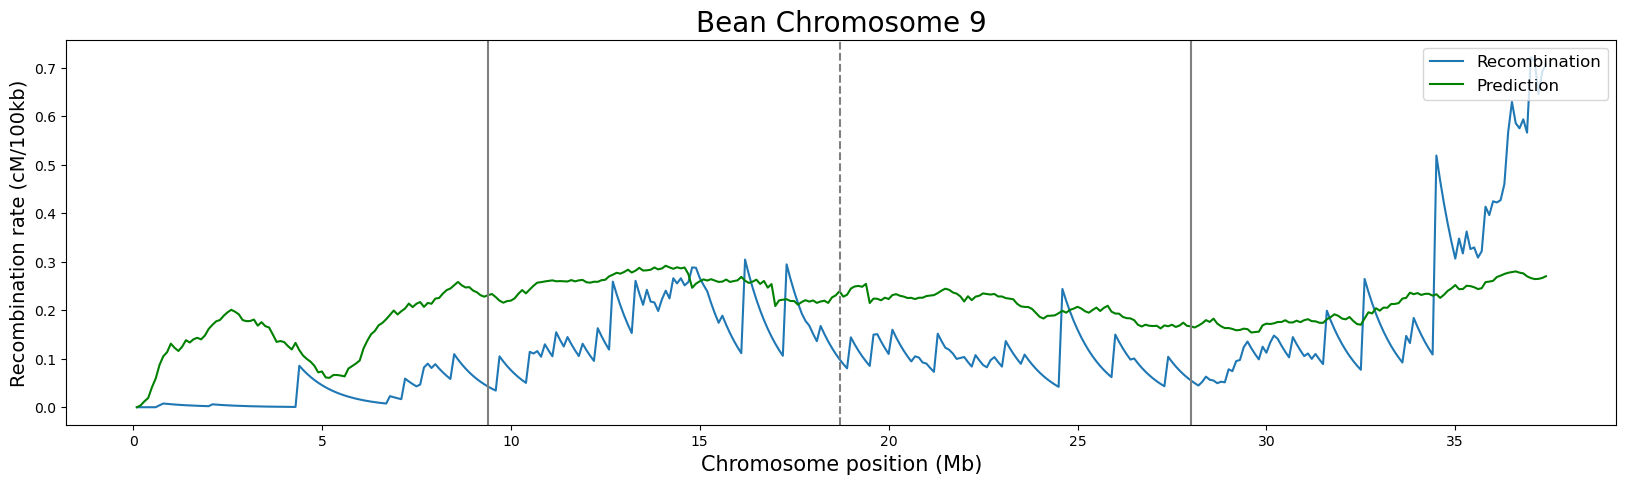

In [15]:
# TRAINING MODEL
X = achr9.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr9.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr9.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr9 = model_spreds      
    
#PARAMETERS
corr_chr9 = pearsonr(chr9.srec, pchr9)
r2_chr9 = r2_score(chr9.srec, pchr9)
mse_chr9 = mean_squared_error(chr9.srec, pchr9)
print('Correlation:', corr_chr9[0])
print('Coefficient of Determination:', r2_chr9)
print('Mean Squared Error:', mse_chr9)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr9)*0.25)
c_q2 = int(len(chr9)*0.50)
c_q3 = int(len(chr9)*0.75)

rq1 = chr9['srec'].iloc[0:c_q1]
rq2 = chr9['srec'].iloc[c_q1:c_q2]
rq3 = chr9['srec'].iloc[c_q2:c_q3]
rq4 = chr9['srec'].iloc[c_q3:int(len(chr9))]

pq1 = pchr9[0:c_q1]
pq2 = pchr9[c_q1:c_q2]
pq3 = pchr9[c_q2:c_q3]
pq4 = pchr9[c_q3:int(len(chr9))]

corr_chr9_q1 = pearsonr(rq1, pq1)
corr_chr9_q2 = pearsonr(rq2, pq2)
corr_chr9_q3 = pearsonr(rq3, pq3)
corr_chr9_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr9. window_end,chr9.srec, label='Recombination')
ax.plot(chr9. window_end,pchr9, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 9',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr9["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7403815707096754
Coefficient of Determination: 0.498302642780175
Mean Squared Error: 0.010171786140494396


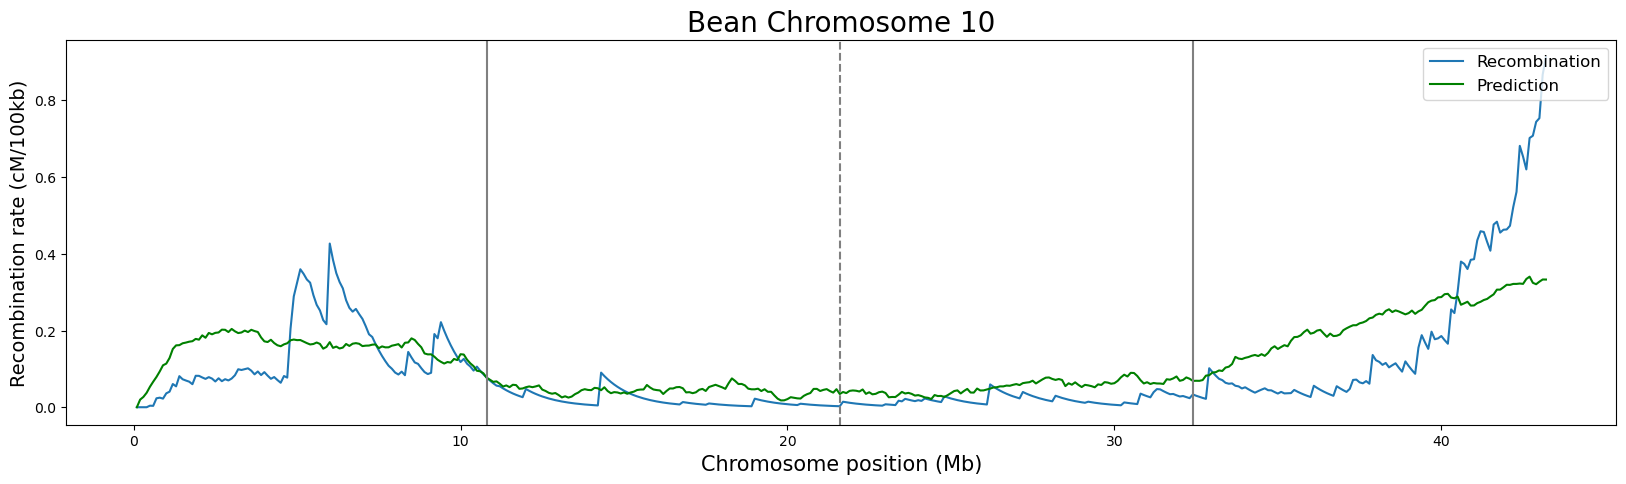

In [16]:
# TRAINING MODEL
X = achr10.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr10.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr10.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr10 = model_spreds      
    
#PARAMETERS
corr_chr10 = pearsonr(chr10.srec, pchr10)
r2_chr10 = r2_score(chr10.srec, pchr10)
mse_chr10 = mean_squared_error(chr10.srec, pchr10)
print('Correlation:', corr_chr10[0])
print('Coefficient of Determination:', r2_chr10)
print('Mean Squared Error:', mse_chr10)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr10)*0.25)
c_q2 = int(len(chr10)*0.50)
c_q3 = int(len(chr10)*0.75)

rq1 = chr10['srec'].iloc[0:c_q1]
rq2 = chr10['srec'].iloc[c_q1:c_q2]
rq3 = chr10['srec'].iloc[c_q2:c_q3]
rq4 = chr10['srec'].iloc[c_q3:int(len(chr10))]

pq1 = pchr10[0:c_q1]
pq2 = pchr10[c_q1:c_q2]
pq3 = pchr10[c_q2:c_q3]
pq4 = pchr10[c_q3:int(len(chr10))]

corr_chr10_q1 = pearsonr(rq1, pq1)
corr_chr10_q2 = pearsonr(rq2, pq2)
corr_chr10_q3 = pearsonr(rq3, pq3)
corr_chr10_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr10. window_end,chr10.srec, label='Recombination')
ax.plot(chr10. window_end,pchr10, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 10',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr10["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.7761277860427283
Coefficient of Determination: 0.43095050828049575
Mean Squared Error: 0.030278389000540216


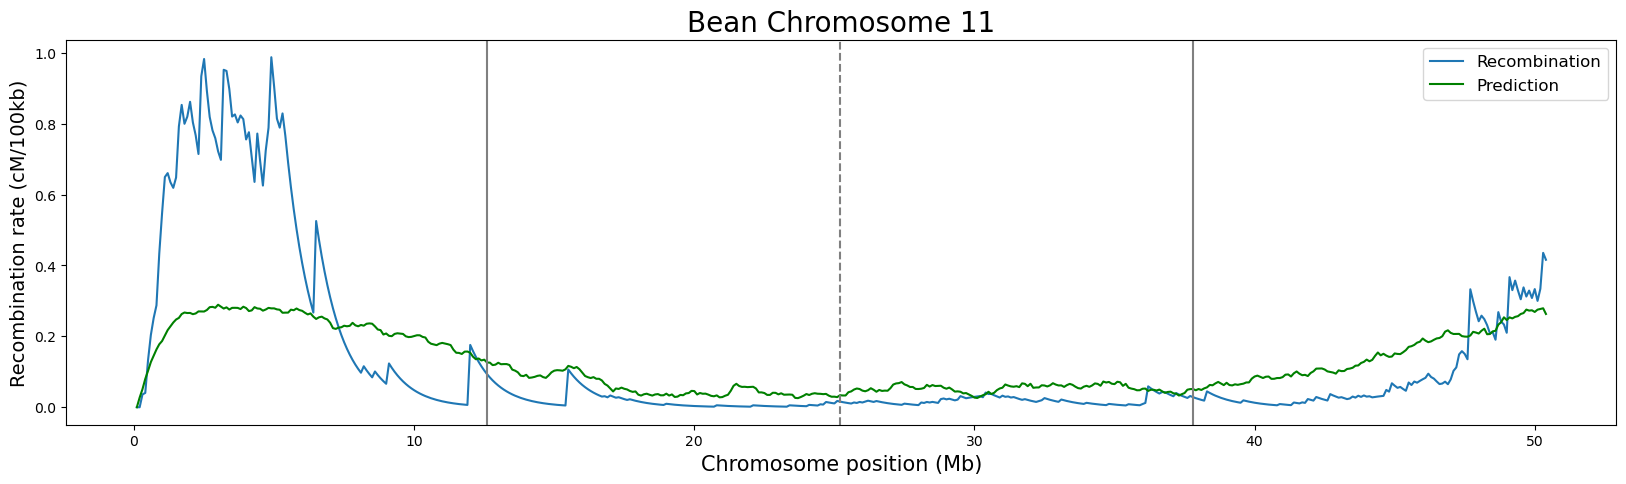

In [17]:
# TRAINING MODEL
X = achr11.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr11.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr11.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr11 = model_spreds      
    
#PARAMETERS
corr_chr11 = pearsonr(chr11.srec, pchr11)
r2_chr11 = r2_score(chr11.srec, pchr11)
mse_chr11 = mean_squared_error(chr11.srec, pchr11)
print('Correlation:', corr_chr11[0])
print('Coefficient of Determination:', r2_chr11)
print('Mean Squared Error:', mse_chr11)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr11)*0.25)
c_q2 = int(len(chr11)*0.50)
c_q3 = int(len(chr11)*0.75)

rq1 = chr11['srec'].iloc[0:c_q1]
rq2 = chr11['srec'].iloc[c_q1:c_q2]
rq3 = chr11['srec'].iloc[c_q2:c_q3]
rq4 = chr11['srec'].iloc[c_q3:int(len(chr11))]

pq1 = pchr11[0:c_q1]
pq2 = pchr11[c_q1:c_q2]
pq3 = pchr11[c_q2:c_q3]
pq4 = pchr11[c_q3:int(len(chr11))]

corr_chr11_q1 = pearsonr(rq1, pq1)
corr_chr11_q2 = pearsonr(rq2, pq2)
corr_chr11_q3 = pearsonr(rq3, pq3)
corr_chr11_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr11. window_end,chr11.srec, label='Recombination')
ax.plot(chr11. window_end,pchr11, label = 'Prediction',  color ='green')
plt.title('Bean Chromosome 11',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr11["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

# Compilation of the prediction results

In [18]:
corr = pd.DataFrame({'corr':[corr_chr1[0], corr_chr2[0], corr_chr3[0], corr_chr4[0], corr_chr5[0], corr_chr6[0], corr_chr7[0], corr_chr8[0], corr_chr9[0], corr_chr10[0], corr_chr11[0]]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9, r2_chr10, r2_chr11]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9, mse_chr10, mse_chr11]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11']})
results = pd.concat([index, corr, r2, mse], axis=1)
results

,chr,corr,R^2,MSE
0,chr1,0.738391,0.476660,0.017712
1,chr2,0.798833,0.548439,0.007689
2,chr3,0.708524,0.462257,0.012431
3,chr4,0.789638,0.513944,0.014944
4,chr5,0.790938,0.391143,0.033561
5,chr6,0.906390,0.728265,0.007065
6,chr7,0.622897,0.003783,0.030858
7,chr8,0.870962,0.728366,0.004882
8,chr9,0.562766,-0.024572,0.016682
9,chr10,0.740382,0.498303,0.010172


In [19]:
results.describe()

,corr,R^2,MSE
count,11.000000,11.000000,11.000000
mean,0.755077,0.432504,0.016934
std,0.099136,0.244271,0.010233
min,0.562766,-0.024572,0.004882
25%,0.723458,0.411047,0.008930
50%,0.776128,0.476660,0.014944
75%,0.794886,0.531192,0.023995
max,0.906390,0.728366,0.033561


Correlation between model predictions and recombination rates by quartiles

In [20]:
corr_q1 = pd.DataFrame({'Q1':[corr_chr1_q1[0], corr_chr2_q1[0], corr_chr3_q1[0], corr_chr4_q1[0], corr_chr5_q1[0], corr_chr6_q1[0], corr_chr7_q1[0], corr_chr8_q1[0], corr_chr9_q1[0], corr_chr10_q1[0], corr_chr11_q1[0]]})
corr_q2 = pd.DataFrame({'Q2':[corr_chr1_q2[0], corr_chr2_q2[0], corr_chr3_q2[0], corr_chr4_q2[0], corr_chr5_q2[0], corr_chr6_q2[0], corr_chr7_q2[0], corr_chr8_q2[0], corr_chr9_q2[0], corr_chr10_q2[0], corr_chr11_q2[0]]})
corr_q3 = pd.DataFrame({'Q3':[corr_chr1_q3[0], corr_chr2_q3[0], corr_chr3_q3[0], corr_chr4_q3[0], corr_chr5_q3[0], corr_chr6_q3[0], corr_chr7_q3[0], corr_chr8_q3[0], corr_chr9_q3[0], corr_chr10_q3[0], corr_chr11_q3[0]]})
corr_q4 = pd.DataFrame({'Q4':[corr_chr1_q4[0], corr_chr2_q4[0], corr_chr3_q4[0], corr_chr4_q4[0], corr_chr5_q4[0], corr_chr6_q4[0], corr_chr7_q4[0], corr_chr8_q4[0], corr_chr9_q4[0], corr_chr10_q4[0], corr_chr11_q4[0]]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

,chr,Q1,Q2,Q3,Q4
0,chr1,0.896932,0.319552,0.665928,0.703004
1,chr2,0.863125,0.317753,-0.063832,0.711491
2,chr3,0.770421,0.452859,0.754108,0.553722
3,chr4,0.814553,0.663401,-0.134745,0.778706
4,chr5,0.937925,0.692265,0.080112,0.821815
5,chr6,0.176558,0.742866,-0.173353,0.736170
6,chr7,0.516006,0.650014,-0.046130,0.792231
7,chr8,0.899562,0.511830,0.449574,0.827687
8,chr9,0.445842,0.433891,0.337011,0.846499
9,chr10,0.272512,0.223895,0.263209,0.760008


# GENERAL STATISTICS ON ALL DATA

### Correlation of features with respect to recombination.

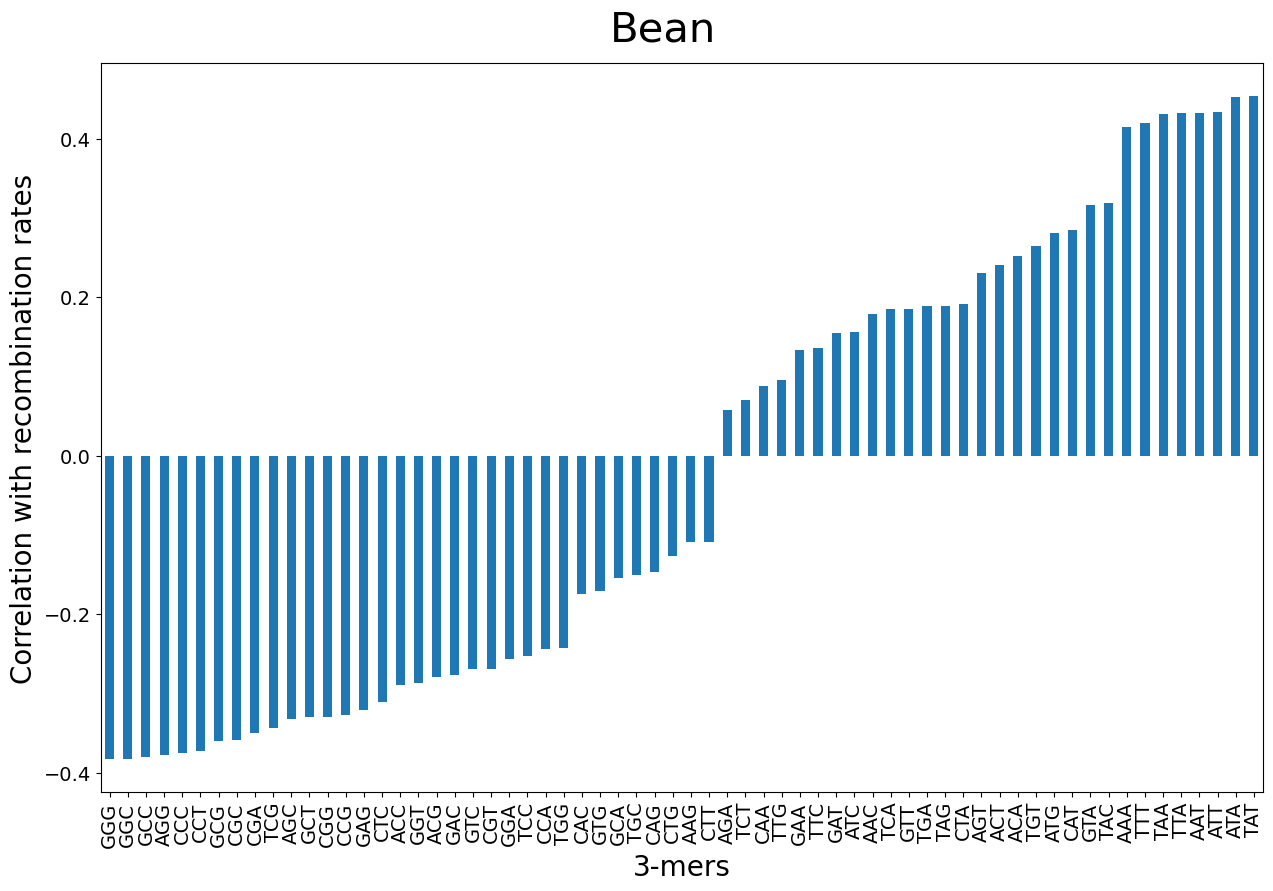

In [21]:
df_stats = df.drop(['chromosome','window_start','window_end','rec'],  axis=1)
df_corr = df_stats.corr()
df_corr = df_corr.iloc[:-1, :]

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df_corr['srec'].sort_values(ascending = True).plot(kind = 'bar')
ax.set_xlabel('3-mers', fontsize=20)
ax.set_ylabel('Correlation with recombination rates', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.suptitle('Bean', fontsize=30)
plt.subplots_adjust(top=0.92)

plt.show()

### Model training with all data

In [22]:
X = df.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = df.srec

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

model =  LinearRegression().fit(X_train, y_train)
predict = model.predict(X_test)

### Linear regression coefficients

In [23]:
coefficients = np.around(model.coef_, 4)
intercept = model.intercept_
table_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': coefficients})
table_coefficients = pd.concat([table_coefficients, pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': [intercept]})], ignore_index=True)
table_coefficients = table_coefficients.transpose()
table_coefficients.columns = table_coefficients.iloc[0]
table_coefficients = table_coefficients.iloc[1:]

bean_lm = table_coefficients
bean_lm.head()

Variable,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Intercept
Coefficient,0.0,0.0025,-0.0023,0.0025,-0.0014,-0.0015,-0.0082,-0.0035,0.0017,0.0026,...,-0.001,-0.0014,-0.0004,-0.002,0.0003,0.0026,-0.0003,0.0003,0.0001,0.068325


In [24]:
bean_lm.to_csv('./bean_3mers_linear_coefficients.csv', index=False) # To save the coefficients in a csv file

### Evaluation of Shap values

PermutationExplainer explainer: 5008it [02:04, 37.64it/s]                                                              


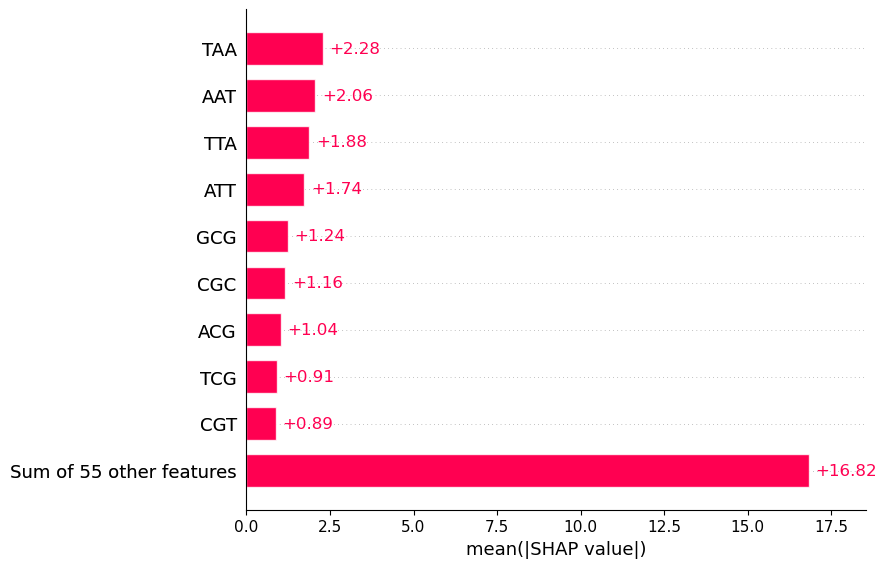

In [25]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)